# **Sentiment prediction with ML methods**

**Study goal**
- This study is based on tha famous IMDB dataset . 
- The goal of the study is not to find the optimal and best solution (because the best performance in this case study was obtained using much more sophisticated methods.
- THe purpose was to practice and illustrate the usage of ML tools for sentiment analysis


**Dataset description**
- the datasource was acquired from Kaggle  https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset/version/1, and contains 50000 reviews for binary classification
- the core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). 
- Among all files provided, only revews texts were used, skipping  sentiment intensity information, source url and other attributes of reviews

**Overall scenario**
- two text representations and three estimators are evaluated using Hyperopt to find hyperparameters

**Contents**
- [Preprocessing](#data_preprocessing)
- [Bag of WOrds representation](#ml_model_with_bow)
- [TF-IDF representation](#tfidf_word_representation)
- [Results and summary Cell](#summary)



In [67]:
import warnings
from Preprocessor import Preprocessor
from Preprocessor import save_obj as save_obj
from Preprocessor import load_obj as load_obj
import datetime as dt
import sys
import os
import pandas as pd
import sklearn
import numpy as np
import multiprocessing
from itertools import product
from copy import deepcopy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn import utils
import hyperopt
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK, pyll

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

NUM_CORES = multiprocessing.cpu_count() // 2 # max num of jobs for parallel processing
versions={'NumPy':np.__version__, 'Pandas':pd.__version__, 'Scikit-learn':sklearn.__version__,
          'Matplotlib': mpl.__version__,'Seaborn':sns.__version__,'Hyperopt':hyperopt.__version__ }
pd.DataFrame.from_dict(versions,orient='index',columns=['Version']).T


,NumPy,Pandas,Scikit-learn,Matplotlib,Seaborn,Hyperopt
Version,1.17.2,0.25.0,0.21.2,3.1.1,0.9.0,0.2


**data loading**

In [2]:
basedir="src_data//"
preproc=Preprocessor()
preproc.load_raw_texts_from_dir(basedir)
preproc.perform_text_cleanup()
preproc.build_datasets()
preproc.build_train_corpus()

Datasets loaded
Dataset: train:pos, number of texts: 12500
Dataset: train:neg, number of texts: 12500
Dataset: test:pos, number of texts: 12500
Dataset: test:neg, number of texts: 12500
Texts cleanup finished in 0:00:27.428066
Storing reviews in two dataframes with shapes: train_data: (25000, 2), test_data: (25000, 2)


**store prepared data for future use**

In [3]:
preproc.save_datasets('preprocessed_data//')
preproc.save_train_corpus('preprocessed_data//')

## **Data preprocessing**
<a id='data_preprocessing'></a>

> **Assumptions**
> - classifiers must be used with unseen data. Test data cannot be used as training or validation set.
> - Therefore among 25000 train records 4/5 will be used for training, and remaining 5000 will be used as validationset
> - The **real performance** of the classifier will be evaluated using the whole test set

> **Supporting functions for text preprocessing**
> - html tags and unicode dropping
> - repeated letters or special characters replacement
> - symbolic chars with special meaning replacement such as "&"="and"
> - contractions replacement i.e. "don't" = "do not"
> - numbers replacement
> - special characters removal
> - stopwords removal
> - stemming or lemmatization
> - negation identifying and marking

> **Potentially benefitial, but not included in preprocessing**
> - replace negations with single word synonyms
> - spelling corrections

All methods used for preprocessing were in Preprocessor.py module

In [4]:
sns.set_style("whitegrid")
sns.set_context("paper")
title_fonts={'fontsize':14, 'weight':'bold'}
axis_label_fonts={'fontsize':12}

# A dictionary to store optimized and fitted models
global_models_dictionary={} 
global_result_dictionary={}
global_prediction_vectors={}

## **ML models with BOW (count based)**
<a id='ml_model_with_bow'></a>
- Bag of Words model was used, based on frequencies of words
- Three classifiers were used: LinearSVC, Bernoulli Naive Bayes, and Logistic Regression (scikit-learn implementation) 
- Optimal hyperparameters for each classifier were found using Hyperopt and crossvalidation with five folds
- Because texts were preprocessed in a pipeline, hyperparameters were the combination of:
> - specific, model-related hyperparameters
> - count vectorizer hyperparameters: maximum frequency, minimum frequency and n-gram range

**parameters for Hyperopt**

In [5]:
# count vectorizer
count_vect=CountVectorizer(encoding='utf-8', ngram_range=(1,1),max_df=1.0, min_df=1, max_features=None,)

# definition of hyperaparameters to be searched for each model
models_bow= {
    'LinearSVC': {
        'pipeline': Pipeline(steps=[('vectorizer',count_vect),('classifier',LinearSVC(max_iter=10000,))]),
        'params': {
            'vectorizer__ngram_range': hp.choice('ngram_range',[(1,3),(1,4),(1,5),(1,6)]),
            'vectorizer__min_df': pyll.scope.int(hp.quniform('min_df',2.5,20.5,1)),
            'vectorizer__max_df':hp.uniform('max_df',0.4, 0.9), 
            'classifier__C':hp.uniform('C',0.8,1.2),
            'classifier__fit_intercept':hp.choice('fit_intercept',[True]),
            'classifier__intercept_scaling':hp.uniform('intercept_scaling',0.9,1.1)
            }
        },
    'BernoulliNB':{
        'pipeline' : Pipeline(steps=[('vectorizer',count_vect),
                                     ('classifier',BernoulliNB(alpha=1.0,binarize=0.0,fit_prior=True))]), 
        'params': {
            'vectorizer__ngram_range': hp.choice('ngram_range',[(1,3),(1,4),(1,5),(1,6)]),
            'vectorizer__min_df': pyll.scope.int(hp.quniform('min_df',2.5,20.5,1)),
            'vectorizer__max_df':hp.uniform('max_df',0.4, 0.9), 
            'classifier__alpha': hp.uniform('alpha',0.5,2),
            }
        },
    'LogisticReg': {
        'pipeline': Pipeline(steps=[('vectorizer',count_vect),
                                    ('classifier',LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                                                     fit_intercept=True, intercept_scaling=1, 
                                                                     solver='liblinear', max_iter=300)
                                    )]),
        'params': {
            'vectorizer__ngram_range': hp.choice('ngram_range',[(1,3),(1,4),(1,5),(1,6)]),
            'vectorizer__min_df': pyll.scope.int(hp.quniform('min_df',2.5,20.5,1)),
            'vectorizer__max_df':hp.uniform('max_df',0.4, 0.9), 
            'classifier__C':hp.uniform('C',0.8,1.2),
            'classifier__fit_intercept':hp.choice('fit_intercept',[True,False]),
            'classifier__intercept_scaling':hp.uniform('intercept_scaling',0.9,1.1)
                        }
                    }
}

**optimization**

Optimizing LinearSVC
100%|███████████████████████████████████████████████| 35/35 [1:35:42<00:00, 149.18s/it, best loss: 0.10771999999999993]
BOW-LinearSVC best accuracy: 0.8923
best params:
{'classifier__C': 0.9142298981229445, 'classifier__fit_intercept': True, 'classifier__intercept_scaling': 1.0445067246210658, 'vectorizer__max_df': 0.5402624315707569, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 5)}


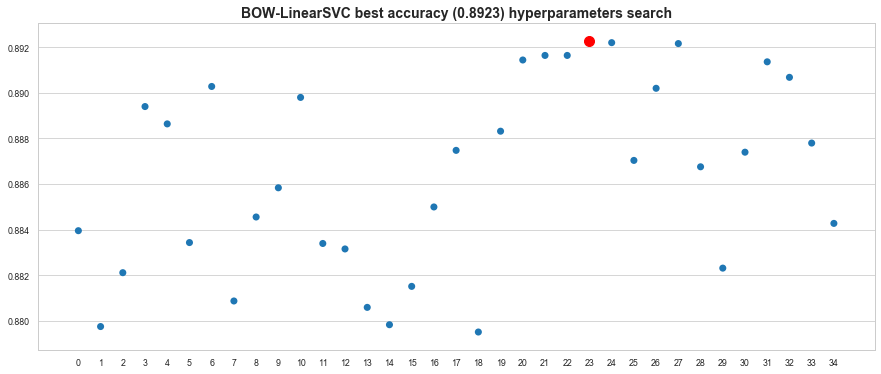

Optimizing BernoulliNB
100%|██████████████████████████████████████████████████| 35/35 [39:59<00:00, 62.34s/it, best loss: 0.11392000000000002]
BOW-BernoulliNB best accuracy: 0.8861
best params:
{'classifier__alpha': 1.798623571664876, 'vectorizer__max_df': 0.405084765564177, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 3)}


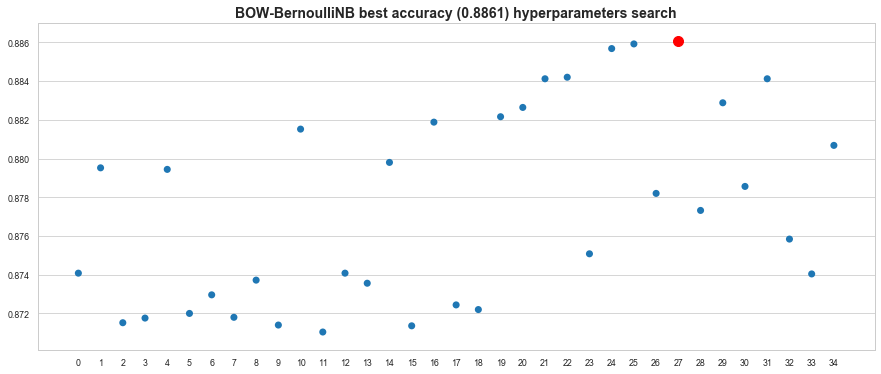

Optimizing LogisticReg
100%|████████████████████████████████████████████████████████████| 35/35 [1:00:25<00:00, 106.70s/it, best loss: 0.1038]
BOW-LogisticReg best accuracy: 0.8962
best params:
{'classifier__C': 1.1999960063898913, 'classifier__fit_intercept': True, 'classifier__intercept_scaling': 1.0113205154018747, 'vectorizer__max_df': 0.43618939332619827, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 5)}


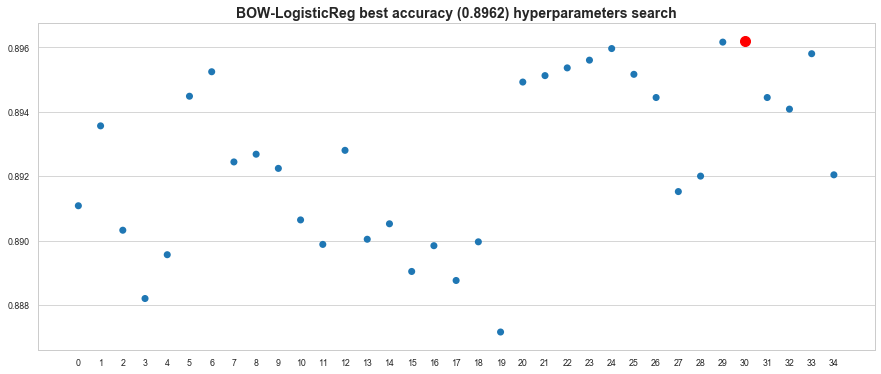

In [6]:
# hyperparameters search
MAX_EVAL=35
kfold = KFold(n_splits=5,random_state=135)

def objective_minimum_local(params):
        estimator.set_params(**params)
        scores = cross_val_score(
            estimator=estimator, X=preproc.train_data['Review'], y=preproc.train_data['Sentiment'], scoring='accuracy', cv=kfold, n_jobs=NUM_CORES)
        loss = 1-np.mean(scores)
        std = np.std(scores)
        return {'loss': loss, 'loss_std': std, 'params': params, 'scores': scores, 
                'optimized_estimator': deepcopy(estimator), 'status': STATUS_OK}

results_bow={}
for model in models_bow:
    start=dt.datetime.now()
    print('Optimizing {}'.format(model))
    bayes_trials = Trials()
    estimator=models_bow[model]['pipeline']
    best=fmin(fn=objective_minimum_local,
              space=models_bow[model]['params'],
              algo=tpe.suggest,
              max_evals=MAX_EVAL,
              trials=bayes_trials,verbose=1
              )

    #results
    print('BOW-{} best accuracy: {:.4f}'.format(model, 1 - bayes_trials.best_trial['result']['loss']))
    print('best params:\n{}'.format(bayes_trials.best_trial['result']['params']))

    fig,ax=plt.subplots(1,1,figsize=(15,6))
    sns.pointplot(x=[x for x in range(len( bayes_trials))],y=[1-trial['result']['loss'] for trial in bayes_trials],linestyles='',markersize=5)
    plt.plot(np.argmax([1-trial['result']['loss'] for trial in bayes_trials]),
             np.max([1-trial['result']['loss'] for trial in bayes_trials]),
             'ro',linewidth=0,markersize=10)
    ax.set_title('BOW-{} best accuracy ({:.4f}) hyperparameters search'.format(model, 1 - bayes_trials.best_trial['result']['loss']),fontdict=title_fonts)
    plt.show()

    # storing
    results_bow[model]={
        'best_params':bayes_trials.best_trial['result']['params'],
        'best cv accuracy': 1 - bayes_trials.best_trial['result']['loss'],
        'optimization duration': dt.datetime.now()-start
    }
save_obj(results_bow,'results//results_bow.pkl')

**summary of BOW results**

In [7]:
for model in models_bow:
    classifier=models_bow[model]['pipeline'].set_params(**results_bow[model]['best_params'])
    global_models_dictionary['BOW-{}'.format(model)]=deepcopy(classifier)      
    classifier.fit(preproc.train_data['Review'],preproc.train_data['Sentiment'])
    y_pred=classifier.predict(preproc.test_data['Review'])
    global_prediction_vectors[('BOW',model)]=y_pred
    print('Classification report for BOW-{}'.format(model))
    classifier_result=classification_report(y_true=preproc.test_data['Sentiment'],
                                            y_pred=y_pred,digits=4,
                                            target_names=['Neg', 'Pos'],
                                            output_dict=True)
    print(pd.DataFrame.from_dict(classifier_result))
    global_result_dictionary[('BOW',model)]=classifier_result

Classification report for BOW-LinearSVC
                    Neg           Pos  accuracy     macro avg  weighted avg
precision      0.893131      0.894391   0.89376      0.893761      0.893761
recall         0.894560      0.892960   0.89376      0.893760      0.893760
f1-score       0.893845      0.893675   0.89376      0.893760      0.893760
support    12500.000000  12500.000000   0.89376  25000.000000  25000.000000
Classification report for BOW-BernoulliNB
                    Neg           Pos  accuracy     macro avg  weighted avg
precision      0.867954      0.895436    0.8812      0.881695      0.881695
recall         0.899200      0.863200    0.8812      0.881200      0.881200
f1-score       0.883301      0.879022    0.8812      0.881161      0.881161
support    12500.000000  12500.000000    0.8812  25000.000000  25000.000000
Classification report for BOW-LogisticReg
                    Neg           Pos  accuracy     macro avg  weighted avg
precision      0.900955      0.898333   

## TFIDF word representation
<a id='tfidf_word_representation'></a>

In [8]:
tfidf_vect=TfidfVectorizer()

models_tfidf= {
    'LinearSVC': {
        'pipeline': Pipeline(steps=[('vectorizer',tfidf_vect),('classifier',LinearSVC(max_iter=3000))]),
        'params': {
            'vectorizer__ngram_range': hp.choice('ngram_range',[(1,1),(1,2),(1,3),(1,4),(1,5),(1,6)]),
            'vectorizer__min_df': pyll.scope.int(hp.quniform('min_df',2.5,20.5,1)),
            'vectorizer__max_df':hp.uniform('max_df',0.4, 0.9), 
            'vectorizer__norm':hp.choice('norm',['l1','l2',None]),
            'vectorizer__use_idf':hp.choice('use_idf',[True,False]),
            'vectorizer__smooth_idf':hp.choice('smooth_idf',[True,False]),
            'vectorizer__sublinear_tf':hp.choice('sublinear_idf',[True,False]),
            'classifier__C':hp.uniform('C',0.8,1.2),
            'classifier__fit_intercept':hp.choice('fit_intercept',[True,False]),
            'classifier__intercept_scaling':hp.uniform('intercept_scaling',0.9,1.1)
            }
        },
    'BernoulliNB':{
        'pipeline' : Pipeline(steps=[('vectorizer',tfidf_vect),
                                     ('classifier',BernoulliNB(alpha=1.0,binarize=0.0,fit_prior=True))]), 
        'params': {
            'vectorizer__ngram_range': hp.choice('ngram_range',[(1,1),(1,2),(1,3),(1,4),(1,5),(1,6)]),
            'vectorizer__min_df': pyll.scope.int(hp.quniform('min_df',2.5,20.5,1)),
            'vectorizer__max_df':hp.uniform('max_df',0.4, 0.9), 
            'vectorizer__norm':hp.choice('norm',['l1','l2',None]),
            'vectorizer__use_idf':hp.choice('use_idf',[True,False]),
            'vectorizer__smooth_idf':hp.choice('smooth_idf',[True,False]),
            'vectorizer__sublinear_tf':hp.choice('sublinear_idf',[True,False]),
            'classifier__alpha': hp.uniform('alpha',0.5,2),
            }
        },
    'LogisticReg': {
        'pipeline': Pipeline(steps=[('vectorizer',tfidf_vect),
                                    ('classifier',LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                                                                     fit_intercept=True, intercept_scaling=1, 
                                                                     solver='liblinear', max_iter=300)
                                    )]),
        'params': {
            'vectorizer__ngram_range': hp.choice('ngram_range',[(1,1),(1,2),(1,3),(1,4),(1,5),(1,6)]),
            'vectorizer__min_df': pyll.scope.int(hp.quniform('min_df',2.5,20.5,1)),
            'vectorizer__max_df':hp.uniform('max_df',0.4, 0.9), 
            'vectorizer__norm':hp.choice('norm',['l1','l2',None]),
            'vectorizer__use_idf':hp.choice('use_idf',[True,False]),
            'vectorizer__smooth_idf':hp.choice('smooth_idf',[True,False]),
            'vectorizer__sublinear_tf':hp.choice('sublinear_idf',[True,False]),
            'classifier__C':hp.uniform('C',0.8,1.2),
            'classifier__fit_intercept':hp.choice('fit_intercept',[True,False]),
            'classifier__intercept_scaling':hp.uniform('intercept_scaling',0.9,1.1)
                        }
                    },    
}

Searching for params LinearSVC
100%|██████████████████████████████████████████████████| 35/35 [41:27<00:00, 88.34s/it, best loss: 0.09131999999999996]
TFIDF-LinearSVC best accuracy: 0.9087
best params:
{'classifier__C': 0.9816177140076223, 'classifier__fit_intercept': False, 'classifier__intercept_scaling': 0.9762382372827344, 'vectorizer__max_df': 0.8956433316000567, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 4), 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': True, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}


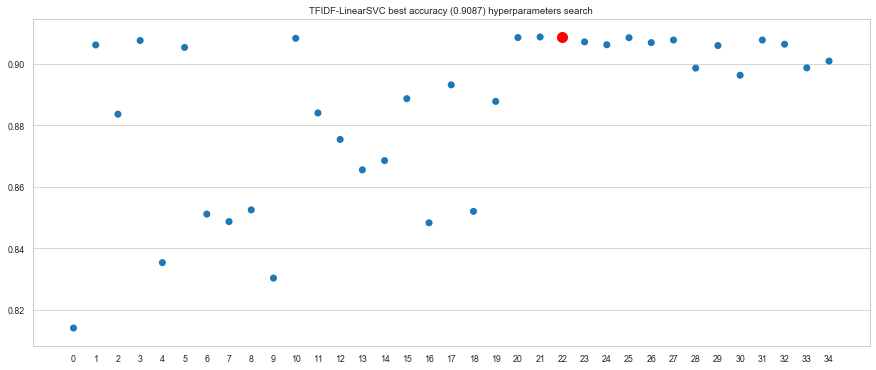

Searching for params BernoulliNB
100%|██████████████████████████████████████████████████| 35/35 [39:39<00:00, 83.17s/it, best loss: 0.11096000000000006]
TFIDF-BernoulliNB best accuracy: 0.8890
best params:
{'classifier__alpha': 0.5215016356771285, 'vectorizer__max_df': 0.7248323657873793, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 4), 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': False, 'vectorizer__sublinear_tf': False, 'vectorizer__use_idf': True}


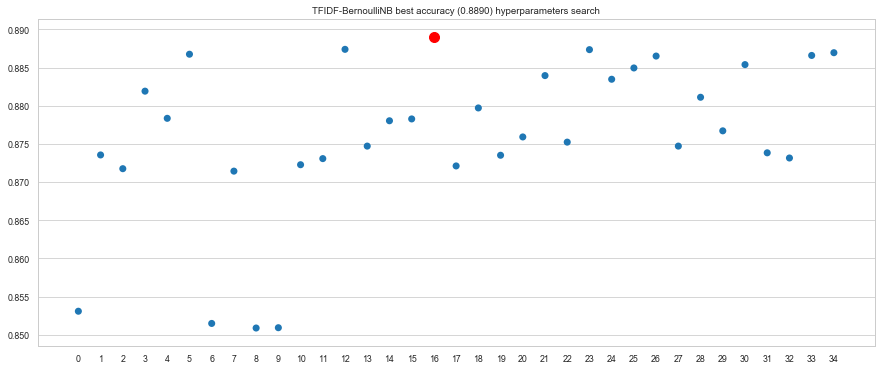

Searching for params LogisticReg
100%|█████████████████████████████████████████████████| 35/35 [43:58<00:00, 103.98s/it, best loss: 0.09507999999999994]
TFIDF-LogisticReg best accuracy: 0.9049
best params:
{'classifier__C': 1.1105975800187717, 'classifier__fit_intercept': False, 'classifier__intercept_scaling': 0.9689968547764448, 'vectorizer__max_df': 0.5177140489772022, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 5), 'vectorizer__norm': None, 'vectorizer__smooth_idf': False, 'vectorizer__sublinear_tf': True, 'vectorizer__use_idf': True}


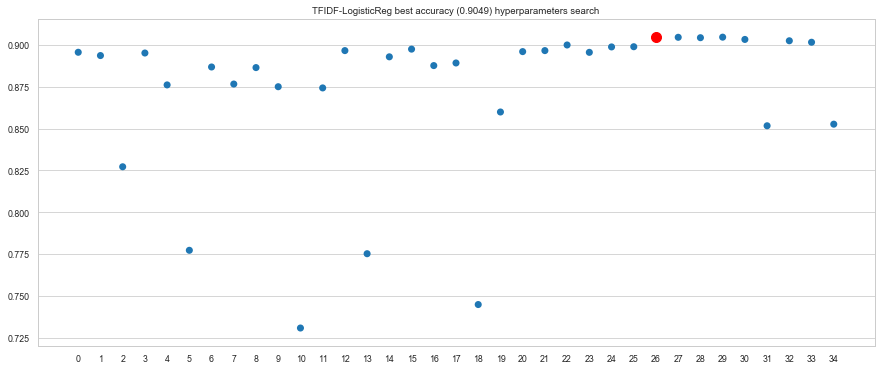

In [9]:
MAX_EVAL=35
kfold = KFold(n_splits=5,random_state=135)

def objective_minimum_local(params):
        estimator.set_params(**params)
        scores = cross_val_score(
            estimator=estimator, X=preproc.train_data['Review'], y=preproc.train_data['Sentiment'], scoring='accuracy', cv=kfold, n_jobs=NUM_CORES)
        loss = 1-np.mean(scores)
        std = np.std(scores)
        return {'loss': loss, 'loss_std': std, 'params': params, 'scores': scores, 
                'optimized_estimator': deepcopy(estimator), 'status': STATUS_OK}

results_tfidf={}
for model in models_tfidf:
    start=dt.datetime.now()
    print('Searching for params {}'.format(model))    
    bayes_trials = Trials()
    estimator=models_tfidf[model]['pipeline']
    best=fmin(fn=objective_minimum_local,
              space=models_tfidf[model]['params'],
              algo=tpe.suggest,
              max_evals=MAX_EVAL,
              trials=bayes_trials
              )

    print('TFIDF-{} best accuracy: {:.4f}'.format(model, 1 - bayes_trials.best_trial['result']['loss']))
    print('best params:\n{}'.format(bayes_trials.best_trial['result']['params']))
    
    fig,ax=plt.subplots(1,1,figsize=(15,6))
    sns.pointplot(x=[x for x in range(len( bayes_trials))],y=[1-trial['result']['loss'] for trial in bayes_trials],linestyles='',markersize=5)
    plt.plot(np.argmax([1-trial['result']['loss'] for trial in bayes_trials]),
             np.max([1-trial['result']['loss'] for trial in bayes_trials]),
             'ro',linewidth=0,markersize=10)
    
    ax.set_title('TFIDF-{} best accuracy ({:.4f}) hyperparameters search'.format(model, 1 - bayes_trials.best_trial['result']['loss']))
    plt.show()
    results_tfidf[model]={
        'best_params':bayes_trials.best_trial['result']['params'],
        'best cv accuracy': 1 - bayes_trials.best_trial['result']['loss'],
        'optimization duration': dt.datetime.now()-start
    }

**summary of TF-IDF results**

In [10]:
for model in models_tfidf:
    print('Classification report for TFIDF-{}'.format(model))
    classifier=models_tfidf[model]['pipeline'].set_params(**results_tfidf[model]['best_params'])
    global_models_dictionary['TFIDF-{}'.format(model)]=deepcopy(classifier)      
    classifier.fit(preproc.train_data['Review'],preproc.train_data['Sentiment'])
    y_pred=classifier.predict(preproc.test_data['Review'])
    global_prediction_vectors[('TFIDF',model)]=y_pred
    classifier_result=classification_report(y_true=preproc.test_data['Sentiment'],
                                            y_pred=y_pred,digits=4,
                                            target_names=['Neg', 'Pos'],
                                            output_dict=True)
    print(pd.DataFrame.from_dict(classifier_result))
    global_result_dictionary[('TFIDF',model)]=classifier_result

Classification report for TFIDF-LinearSVC
                    Neg           Pos  accuracy   macro avg  weighted avg
precision      0.908865      0.908735    0.9088      0.9088        0.9088
recall         0.908720      0.908880    0.9088      0.9088        0.9088
f1-score       0.908793      0.908807    0.9088      0.9088        0.9088
support    12500.000000  12500.000000    0.9088  25000.0000    25000.0000
Classification report for TFIDF-BernoulliNB
                    Neg           Pos  accuracy     macro avg  weighted avg
precision      0.882362      0.889463   0.88588      0.885913      0.885913
recall         0.890480      0.881280   0.88588      0.885880      0.885880
f1-score       0.886403      0.885353   0.88588      0.885878      0.885878
support    12500.000000  12500.000000   0.88588  25000.000000  25000.000000
Classification report for TFIDF-LogisticReg
                    Neg           Pos  accuracy    macro avg  weighted avg
precision      0.905223      0.905417   0.905

In [11]:
save_obj(global_models_dictionary,'results//global_models_dictionary.pkl') 
save_obj(global_result_dictionary,'results//global_result_dictionary.pkl')
save_obj(global_prediction_vectors,'results//global_prediction_vectors')

## Summary of results obtained from ML classifiers
<a id='summary'></a>

In [12]:
result_df=pd.DataFrame.from_dict({m:global_result_dictionary[m]['accuracy'] for m in global_result_dictionary},orient='index').reset_index()
result_df['Vectoriser']=result_df.apply(lambda x: x['index'][0],axis=1)
result_df['Model']=result_df.apply(lambda x: x['index'][1],axis=1)
result_df=result_df[['Vectoriser','Model',0,]]
result_df=result_df.rename({0:'Accuracy'},axis=1)

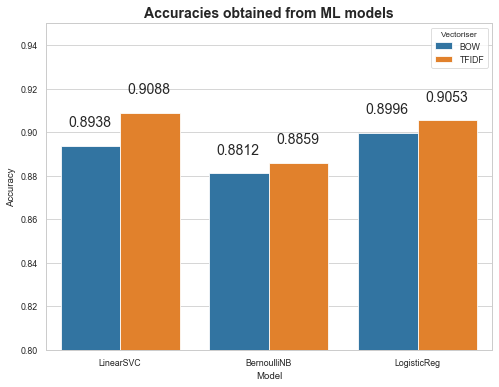

In [13]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
sns.barplot(data=result_df,x='Model',y='Accuracy',hue='Vectoriser',ax=ax)
ax.set_ylim((0.8,0.95))
ax.set_title('Accuracies obtained from ML models', fontdict=title_fonts)
for p in ax.patches:
    ax.text(x=p.get_x()+0.25*p.get_width()/2,y=p.get_y()+p.get_height()*1.01,s='{:.4f}'.format(p.get_height()),fontdict={'fontsize':14})

**Comment**

To summarise, we may see that classic ML classifiers employed performed quite well. <br>
Their results are quite far from the best score achieved to date (97,4 with NB-weighted-BON + dv-cosine, please see: https://paperswithcode.com/sota/sentiment-analysis-on-imdb), but is still similar to those obtained with more advanced methods.

Furthermore, the performance of traditional ML models can be probably improved using more sophisticated methods like classifier stacking or just simply averaging.
The important question is wheather the classifiers make mistakes with relation to the same or various reviews.

As we can see on the diagram below around 20% of mistakes were made by less than three (a half of) classifiers.
We could expect that there is a space for slight improvement by a technique like simple voting or averaging the classifiers.

Being not perfect in comparison to the leader (97,4%), the performance of ML algorithms is stil quite similar to other much more sophisticated approaches.  

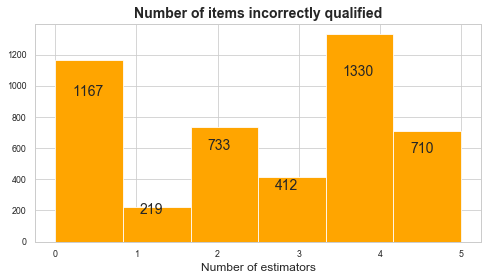

In [57]:
predicted_vectors=pd.DataFrame.from_dict(global_prediction_vectors)
predicted_vectors.index=preproc.test_data['Sentiment'].index
predicted_vectors_=pd.DataFrame(index=predicted_vectors.index)
for col in predicted_vectors.columns:
    predicted_vectors_[col]=predicted_vectors[col].eq(preproc.test_data['Sentiment'])
predicted_vectors_=predicted_vectors_.applymap(lambda x: 1 if x else 0)
predictions=predicted_vectors_.sum(axis=1)
fig,ax=plt.subplots(1,1,figsize=(8,4))
ax=predictions[predictions<6].hist(bins=6,ax=ax,color='orange')
for p in ax.patches:
    ax.text(x=p.get_x()+0.5*p.get_width()/2,y=p.get_y()+p.get_height()*0.8,s='{:.0f}'.format(p.get_height()),fontdict={'fontsize':14})
ax.set_title('Number of items incorrectly qualified',fontdict=title_fonts)
ax.set_xlabel('Number of estimators', fontdict=axis_label_fonts);
ax